In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [19]:
owid_covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
owid_covid_data.head()


,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand
0,AFG,Asia,Afghanistan,2019-12-31,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
1,AFG,Asia,Afghanistan,2020-01-01,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
2,AFG,Asia,Afghanistan,2020-01-02,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
3,AFG,Asia,Afghanistan,2020-01-03,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
4,AFG,Asia,Afghanistan,2020-01-04,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5


In [55]:
Clean_Data = TodaysData_Country.drop([ 'Report_Date_String','Delta_Confirmed','Delta_Recovered','Incident_Rate','People_Tested','People_Hospitalized','FIPS','UID','iso3'], axis=1) 
Clean_Data = Clean_Data[Clean_Data['Province_State'].isnull()]
Clean_Data.tail()

In [75]:
Data_To_Process =pd.DataFrame(columns=['date','location', 'total_deaths','total_cases'], data=owid_covid_data[['date','location', 'total_deaths','total_cases']].values)
Data_To_Process.head()

,date,location,total_deaths,total_cases
0,2019-12-31,Afghanistan,0,0
1,2020-01-01,Afghanistan,0,0
2,2020-01-02,Afghanistan,0,0
3,2020-01-03,Afghanistan,0,0
4,2020-01-04,Afghanistan,0,0


In [77]:
# Predict Death Using Prophet
#Get Data for US


Data_To_Process = Data_To_Process.query('location=="United States"' )
Data_To_Process.tail(10)

,date,location,total_deaths,total_cases
21183,2020-05-28,United States,100442,1699933
21184,2020-05-29,United States,101617,1721750
21185,2020-05-30,United States,102836,1747087
21186,2020-05-31,United States,103781,1770384
21187,2020-06-01,United States,104383,1790191
21188,2020-06-02,United States,105147,1811277
21189,2020-06-03,United States,106181,1831821
21190,2020-06-04,United States,107175,1851520
21191,2020-06-05,United States,108211,1872660
21192,2020-06-06,United States,109143,1897838


In [78]:
from fbprophet import Prophet
cases = Data_To_Process.groupby('date').sum()['total_cases'].reset_index()
deaths = Data_To_Process.groupby('date').sum()['total_deaths'].reset_index()


In [79]:
#Clean the Data
# Prphet expect Dataframe with columns "ds" and "y" with the dates and values respectively
deaths.rename(columns={'Last_Update': 'date','total_deaths':'y'}, inplace=True)
deaths.columns = ['ds', 'y']
deaths.tail()


,ds,y
154,2020-06-02,105147
155,2020-06-03,106181
156,2020-06-04,107175
157,2020-06-05,108211
158,2020-06-06,109143


In [80]:
#Create the model using Prophet 0.95 confidence
ML_Model = Prophet(interval_width=0.95)
#Fit the Model
ML_Model.fit(deaths)
#Create prediction Data
Death_Prediction = ML_Model.make_future_dataframe(periods=60)
Death_Prediction.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
214,2020-08-01
215,2020-08-02
216,2020-08-03
217,2020-08-04
218,2020-08-05


In [81]:
#predicting the future with date, and upper and lower limit of y value
Death_Forecast = ML_Model.predict(Death_Prediction)
Death_Forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
214,2020-08-01,180640.046087,141401.192417,217347.191567
215,2020-08-02,181918.091568,141221.903696,220315.958995
216,2020-08-03,182902.759157,142317.305714,221859.082797
217,2020-08-04,183936.660359,141869.792219,224210.728830
218,2020-08-05,185237.877863,141675.256252,226372.909290


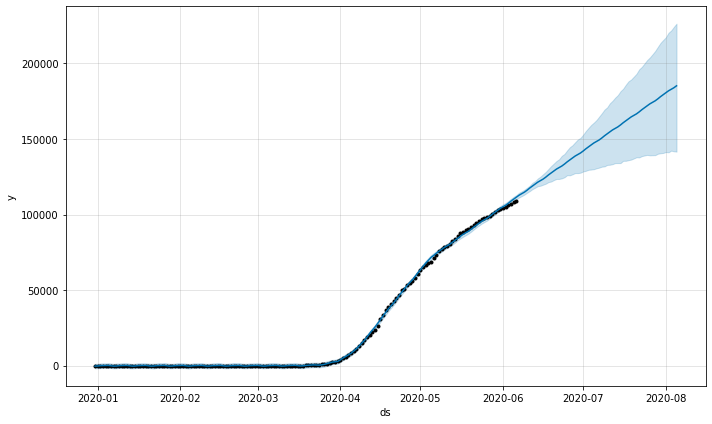

In [82]:
Death_forecasting = ML_Model.plot(Death_Forecast)

In [13]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [14]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [17]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

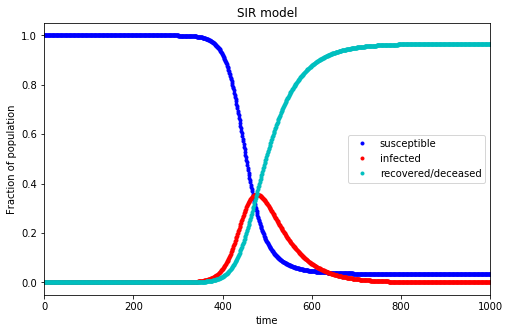

In [18]:
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.savefig('SIR_example.png')
plt.show()